# Notebook for Processing AQI Data

In [74]:
# Imports
import pandas as pd
import pickle
import matplotlib

In [76]:
def fill_missing_aqi(df, start_date, end_date):
    df['AQI'] = df['AQI'].astype('int')
    expected_dates = pd.date_range(start=start_date, end=end_date)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date').reindex(expected_dates).reset_index()
    df = df.rename(columns={'level_0': 'Date'})
    replacement_values = dict()
    for i in range(len(df)):
        if pd.isna(df.at[i, 'AQI']):
            before_index = i - 1
            after_index = i + 1
            while before_index >= 0 and pd.isna(df.at[before_index, 'AQI']):
                before_index -= 1
            while after_index < len(df) and pd.isna(df.at[after_index, 'AQI']):
                after_index += 1
            if before_index < 0:
                val = df.at[after_index, 'AQI']
            elif after_index >= len(df):
                val = df.at[before_index, 'AQI']
            else:
                val = (df.at[before_index, 'AQI'] + df.at[after_index, 'AQI']) // 2
            replacement_values[i] = val
    for i in range(len(df)):
        if i in replacement_values:
            df.at[i, 'AQI'] = replacement_values[i]
    df = df[['Date', 'AQI']]
    return df

In [77]:
df_list = []

start_year = 2017
end_year = 2023

for year in range(start_year, end_year):
    data = pd.read_csv(f"daily_aqi_by_county_{year}.csv")
    data_virginia_only = data[data['county Name'] == 'Albemarle'].sort_values('Date').reset_index()
    df_list.append(data_virginia_only)

total_data = pd.concat(df_list, ignore_index=True)
total_data_cleaned = fill_missing_aqi(total_data, f'{start_year}-01-01', f'2022-09-26')
print(total_data_cleaned)

           Date   AQI
0    2017-01-01  33.0
1    2017-01-02  18.0
2    2017-01-03   6.0
3    2017-01-04  11.0
4    2017-01-05  13.0
...         ...   ...
2090 2022-09-22  21.0
2091 2022-09-23   8.0
2092 2022-09-24  12.0
2093 2022-09-25  12.0
2094 2022-09-26  17.0

[2095 rows x 2 columns]


In [78]:
with open('cleaned_aqi_data.pkl', 'wb') as f:
    pickle.dump(total_data_cleaned, f)

<Axes: xlabel='Date'>

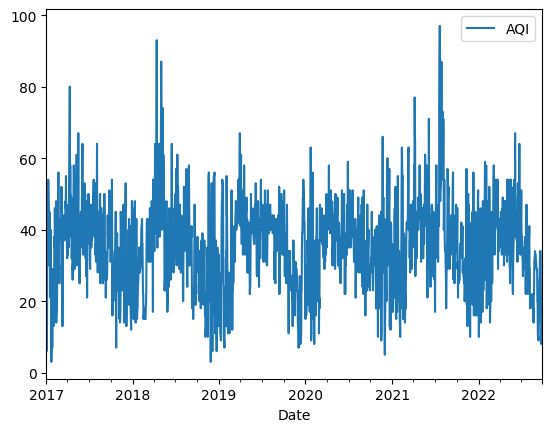

In [79]:
total_data_cleaned.plot(x='Date', y='AQI')

<Axes: xlabel='Date'>

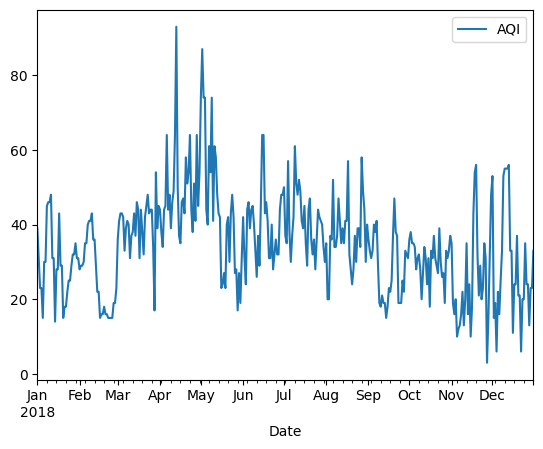

In [82]:
data_2018 = total_data_cleaned[(total_data_cleaned['Date'] >= '2018-01-01') & (total_data_cleaned['Date'] <= '2018-12-31')]
data_2018.plot(x='Date', y='AQI')